This notebook will deal with the resampling and comparison of single and multi bat context audio segments. 

### Observed audio split-measurements
Each video annotation was matched with a corresponding length of audio, and each annotation also had the number of bats seen in the video. In the previous notebook ('Split measuring all valid...'), each annotation audio was split into 50ms segments and various measurements were carried out on them (rms, -20dB frequency, dominant frequency). 

### Virtual multi-bat audio split-measurements
The same protocol for the observed audio split-measurements was followed to keep the measurements comparable. The main difference if that the audio analysed here were actually synthetic. The 'virtual' multi bat audio were made by adding two or three duration matched single bat files. This mimics a situation where two bats are echolocating in the recording volume, without showing any response to each other. 


### Reducing the extent of pseudo-replication in the natural observations through bootstrapping

In the current notebook I will now load the previous measurements of segments that had a non-negligible rms (+20dB above the level calculated for silent audio segments). These measurements contain measurement values for multiple segments from the same audio file. Comparing the measurements from all segments together may lead to spurious results because of the extent of pseudo-replication in the data. This is because, not only are the segments from the same audio file, but even many of the audio files are from the same hour. 

Resampling to take out the measurements from one segment per audio file will help reduce the extent of pseudo-replication. 

### Comparisons to be performed
*Update (2020-08-25): in a previous version of this notebook I had calculated $\Delta$median differences between the 3 pairs derived from the three 'groups' we have. After discussion with NMR and HRG, we decided the $\Delta$median is not the most biologically relevant way to present all the data. Different parameters need to be tested with different methods as is relevant. More importantly, it was also decided that it's better to first study the bootstrapped median values before jumping into the $\Delta$median values*

The bootstrapped median values will be calculated for all parameters across all groups. A single window will be chosen from each annotation matched audio file and this will be used to generate the median value. The median value is sensible to compare for certain parameters eg. peak amplitude, rms, lower frequency. For other parameters it is less relevant, eg. dominant frequencies.

For parameters like dominant frequencies, the more relevant question is whether the frequency distributions overlap or not. It is not so much of interest whether the overall median is higher or lower, but rather whether the overall dominant frequency distributions are similar. The question is more holistically focussed. 


In [1]:
import datetime as dt
import sys 
sys.path.append('../')
sys.path.append('../../individual_call_analysis/analysis/')
from measure_annot_audio.inbuilt_measurement_functions import dB
from shuffle_overlap import shuffle_overlap
import joblib
from joblib import Parallel, delayed
import shutil
import matplotlib.pyplot as plt
import numpy as np 
np.random.seed(82319)
import pandas as pd
import scipy.stats 
import tqdm

In [2]:
%matplotlib notebook

In [66]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [4]:
split_measure = pd.read_csv('non_silent_measurements_20dBthreshold.csv')
split_measure['type'] = 'observed'

virtual_split_measure = pd.read_csv('non_silent_virtual_multibat_measurements_20dBthreshold.csv')
virtual_split_measure['type'] = 'virtual'

### Adding virtual multibat into the split measure
I will add the virtual multibat files  into a common split measure DataFrame, but also include the 'type' column to prevent confusion. 

In [5]:
all_measures = pd.concat([split_measure, virtual_split_measure]).reset_index(drop=True)

# a stupid hack to fix the pairing order in a deterministic way. 
# Among the three pairs possible, the order is always the following single-multi, single-multi(virtual), multi(observed)-multi(virtual)
group_and_type = []
for i, row in all_measures.iterrows():
    row_type = row['type']
    num_bats = row['num_bats']
    if num_bats>1:
        single_or_multi = '1multi'
    else:
        single_or_multi = '0single'
    
    group_and_type.append(single_or_multi + '_' + row_type)

all_measures['group_type'] = group_and_type

In [6]:
np.unique(group_and_type)

array(['0single_observed', '1multi_observed', '1multi_virtual'],
      dtype='<U16')

In [7]:
all_measures.head()

,Unnamed: 0,value,segment_number,measurement,file_name,unique_window_id,video_annot_id,num_bats,type,group_type
0,0,0.032661,0,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
1,1,0.102295,0,peak_amplitude,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
2,2,90200.000000,0,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
3,3,104700.000000,0,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
4,4,0.020559,3,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2,observed,1multi_observed


In [8]:
split_measure.head()

,Unnamed: 0,value,segment_number,measurement,file_name,unique_window_id,video_annot_id,num_bats,type
0,0,0.032661,0,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed
1,1,0.102295,0,peak_amplitude,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed
2,2,90200.000000,0,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed
3,3,104700.000000,0,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed
4,4,0.020559,3,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2,observed


In [9]:
virtual_split_measure.head()

,Unnamed: 0,value,segment_number,measurement,file_name,unique_window_id,video_annot_id,num_bats,type
0,0,0.040565,0,rms,matching_annotaudio_Aditya_2018-08-17_01_29_hp...,0_matching_annotaudio_Aditya_2018-08-17_01_29_...,Aditya_2018-08-17_01_29,2,virtual
1,1,0.148834,0,peak_amplitude,matching_annotaudio_Aditya_2018-08-17_01_29_hp...,0_matching_annotaudio_Aditya_2018-08-17_01_29_...,Aditya_2018-08-17_01_29,2,virtual
2,2,103440.000000,0,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-17_01_29_hp...,0_matching_annotaudio_Aditya_2018-08-17_01_29_...,Aditya_2018-08-17_01_29,2,virtual
3,3,103660.000000,0,dominant_frequencies,matching_annotaudio_Aditya_2018-08-17_01_29_hp...,0_matching_annotaudio_Aditya_2018-08-17_01_29_...,Aditya_2018-08-17_01_29,2,virtual
4,4,105920.000000,0,dominant_frequencies,matching_annotaudio_Aditya_2018-08-17_01_29_hp...,0_matching_annotaudio_Aditya_2018-08-17_01_29_...,Aditya_2018-08-17_01_29,2,virtual


### Number of segments per annotation


In [10]:
by_audio_file = all_measures.groupby(['file_name'])

all_window_counts = []
for filename, df in by_audio_file:
    df_rms = df[df['measurement']=='rms']
    num_windows = df_rms.shape[0]
    all_window_counts.append(num_windows)

summary_counts = np.percentile(all_window_counts, [0,25,50, 75,100])
print(summary_counts)

[ 1.  3.  6. 11. 86.]


<IPython.core.display.Javascript object>


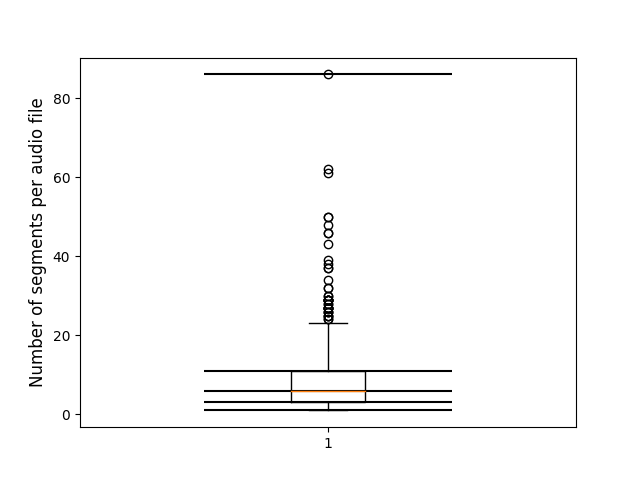

In [11]:
plt.figure()
plt.boxplot(all_window_counts); plt.ylabel('Number of segments per audio file', fontsize=12)
plt.hlines(summary_counts, 0.75, 1.25)

The four black lines represent the minimum, first quartile, median, third quartile and the maximum. As can be the seen the minimum is 1 segment per file, while the general norm is between 3 to 10 segments per file. There are also some files with upto more than 20 segments too!!! Without accounting for the difference in segments contributed by each file, the results may just be biased by how many segments each audio file contributes.

### A broad look at parameters across group-sizes, does the data look okay?

In [33]:
def split_into_single_multi_and_virtual(df):
    '''
    Splits all split-measurements into single, multi and virtual multi bat 
    DataFrames.
    '''
    single_bat = df[df['num_bats']==1].reset_index(drop=True)
    
    real_multi_bat = np.logical_and(df['num_bats']>1, df['type']=='observed')
    multi_bat  = df[real_multi_bat].reset_index(drop=True)
    virtual_multi_bat = np.logical_and(df['num_bats']>1, df['type']=='virtual')
    virtual_multibat = df[virtual_multi_bat]
    return single_bat, multi_bat, virtual_multibat

def extract_one_measurement(df,measurement_name):
    '''
    '''
    one_measurement = df[df['measurement']==measurement_name].reset_index(drop=True)
    return one_measurement


def calc_group_type_summary(df, measurement_name, summary_fn, proc_fun:lambda X:X):
    '''
    Splits the df into three groups based on the column 'group_type'. 
    If there are more than two group types, then an error is raised
    
    '''
    
    df_bygrouptype = split_into_grouptypes(df)
    if len(df_bygrouptype)!=3:
        raise ValueError('There must be 3 group types for this analysis')
    df_grouptypes = [each[each['measurement']==measurement_name]  for each in df_bygrouptype]
    
    summary_grouptypes = [summary_fn(proc_fun(each_df['value'])) for each_df in df_grouptypes] 
    summary1, summary2, summary3 = summary_grouptypes
    return summary1, summary2, summary3

def split_into_grouptypes(df):
    '''
    splits the dataframes by group type
    '''
    group_types = np.unique(df['group_type'])
    return [df[df['group_type']==each] for each in group_types]
    

def extract_single_multi_virtualmulti_by_measurement(df, measurement_name):
    '''
    '''
    by_measurements = df[df['measurement']==measurement_name].reset_index(drop=True)
    single, multi, virtual_multi = split_into_single_multi_and_virtual(by_measurements)
    return single, multi, virtual_multi

def make_inspection_and_comparison_plot(df, measurement_name, process_fn=lambda X: X):
    '''
    '''
    single, multi, virtual_multi = extract_single_multi_virtualmulti_by_measurement(df, measurement_name)
    plt.figure(figsize=(8,4))
    plt.violinplot([process_fn(single['value'].to_numpy()),
                    process_fn(multi['value'].to_numpy()),
                    process_fn(virtual_multi['value'].to_numpy())],
                   [0, 1, 2], showmedians=True,
                  quantiles=[[0.25,0.75],[0.25,0.75],[0.25,0.75],]);    
    plt.xticks([0,1,2],['single','multi', 'virtual multi'])
    plt.ylabel(measurement_name, fontsize=12)

In [94]:
def resample_one_segment_from_each_audio(df):
    '''
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with the following compulsory columns
        file_name, segment_number
    Returns 
    -------
    one_seg_per_file : pd.DataFrame
        A subset of all rows, but with only one segment per file chosen. 
    '''
    by_filename = df.groupby(['file_name'])
    #resampled_data = [choose_one_segment(each) for each in by_filename]
    resampled_data = by_filename.apply(choose_one_segment)
    one_seg_per_file = resampled_data.reset_index(drop=True)
    return one_seg_per_file

def choose_one_segment(sub_df):
    #filename, sub_df = filename_and_subdf
    # if there are >1 valid segments in the audio file, then select just one randomly
    segments = sub_df['segment_number'].tolist()
    if len(segments) == 1:
        return sub_df
    else:
        one_segment = int(np.random.choice(segments, 1))
        chosen_rows = sub_df['segment_number']==one_segment
        chosen_df = sub_df[chosen_rows]
        return chosen_df
    


In [89]:
by_seg = all_measures.groupby(['segment_number'])
by_seg.get_group(0).reset_index(drop=True)

,Unnamed: 0,value,segment_number,measurement,file_name,unique_window_id,video_annot_id,num_bats,type,group_type
0,0,0.032661,0,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
1,1,0.102295,0,peak_amplitude,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
2,2,90200.000000,0,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
3,3,104700.000000,0,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
4,15,0.045400,0,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_18,2,observed,1multi_observed
...,...,...,...,...,...,...,...,...,...,...
1559,8099,0.032639,0,rms,matching_annotaudio_Aditya_2018-08-16_2324_59_...,0_matching_annotaudio_Aditya_2018-08-16_2324_5...,Aditya_2018-08-16_2324_59,3,virtual,1multi_virtual
1560,8100,0.141174,0,peak_amplitude,matching_annotaudio_Aditya_2018-08-16_2324_59_...,0_matching_annotaudio_Aditya_2018-08-16_2324_5...,Aditya_2018-08-16_2324_59,3,virtual,1multi_virtual
1561,8101,105400.000000,0,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-16_2324_59_...,0_matching_annotaudio_Aditya_2018-08-16_2324_5...,Aditya_2018-08-16_2324_59,3,virtual,1multi_virtual
1562,8102,105620.000000,0,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_2324_59_...,0_matching_annotaudio_Aditya_2018-08-16_2324_5...,Aditya_2018-08-16_2324_59,3,virtual,1multi_virtual


In [35]:
def shuffle_values_between_grouptypes(df, measurement_name):
    '''
    '''
    single_df, multi_df = split_into_two_grouptypes(df)
    single, multi = [each[each['measurement']==measurement_name] for each in [single_df, multi_df]]
    single_rows, multi_rows = single.shape[0], multi.shape[0]
    # swap values between single and multi bat annotations
    all_values = np.concatenate([single['value'], multi['value']]).flatten()
    np.random.shuffle(all_values)
    single['value'] = all_values[:single_rows]
    multi['value'] = all_values[single_rows:]
    return single, multi

def make_shuffled_df(df, measurement_name):
    shuffled_single, shuffled_multi = shuffle_values_between_grouptypes(df, measurement_name)
    joined = pd.concat([shuffled_single, shuffled_multi]).reset_index(drop=True)
    return joined
    
def just_return_input(X):
    return X

In [36]:
def calculate_observed_and_shuffled_overlap(df, measurement_name, summary_fn, proc_fn, num_shuffles=500):
    '''
    '''
    observed_shuffled_BC = Parallel(n_jobs=4)(delayed(get_observed_and_shuffled)(df, measurement_name, summary_fn, proc_fn) for i in tqdm.tqdm(range(num_shuffles)))
    observed = [each[0] for each in observed_shuffled_BC]
    shuffled =  [each[1] for each in observed_shuffled_BC]

    return observed, shuffled
        

def get_observed_and_shuffled(df, measurement_name, summary_fn, proc_fn):
    one_segment = resample_one_segment_from_each_audio(df)
    group_type1_measures, group_type2_measures = calc_group_type_summary(one_segment, 
                                                                          measurement_name, 
                                                                          summary_fn, proc_fn)
    this_run_BC, _ = shuffle_overlap.calculate_overlap(group_type1_measures, group_type2_measures)

    # now do the data shuffling
    shuffled_segment = make_shuffled_df(one_segment, measurement_name)
    grouptype1_shufmeasures, grouptype2_shufmeasures = calc_group_type_summary(shuffled_segment, 
                                                                          measurement_name, 
                                                                          summary_fn, proc_fn)
    this_run_shufBC, _ = shuffle_overlap.calculate_overlap(grouptype1_shufmeasures, grouptype2_shufmeasures)
    return this_run_BC, this_run_shufBC

In [58]:
def calculate_bootstrapped_median_across_grouptypes(df, measurement_name, summary_fn,proc_fn):
    '''
    A DataFrame with 2 group types is taken, bootstrapped and the delta median 
    between the two group types is repeatedly calculated
    
    
    Returns
    -------
    median_data : 
    '''
    one_segment = resample_one_segment_from_each_audio(df)
    group123_measures = calc_group_type_summary(one_segment, 
                                                          measurement_name, 
                                                      summary_fn, proc_fn)
    median_data = list(map(np.median, group123_measures))
    
    return median_data

def bootstrapped_median_distribution(df, measurement_name, summary_fn,proc_fn, Nruns=500, parallel=False):
    '''
    '''
    if parallel:
        all_median_data = Parallel(n_jobs=4)(delayed(calculate_bootstrapped_median_across_grouptypes)(df, 
                                                                                                  measurement_name, summary_fn,proc_fn,) for i in tqdm.trange(Nruns))
    else:
        all_median_data = [calculate_bootstrapped_median_across_grouptypes(df,   measurement_name, summary_fn,proc_fn,) for i in tqdm.trange(Nruns)]

    num_groups  = len(all_median_data[0])
    reshaped_median_data = np.concatenate(all_median_data).reshape(-1,num_groups)
    return reshaped_median_data


### Peak amplitude

<IPython.core.display.Javascript object>


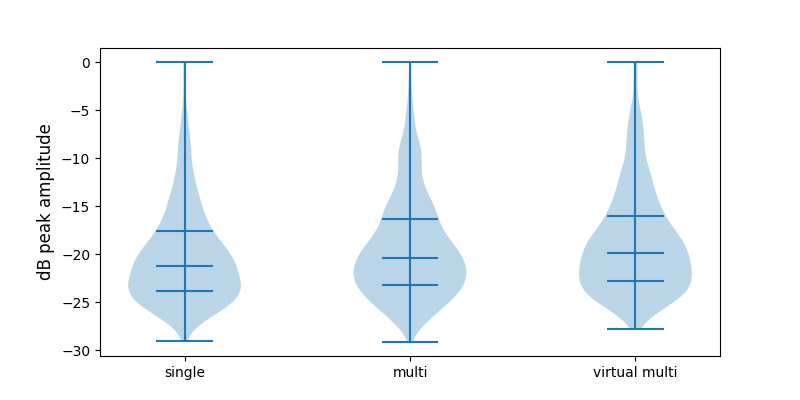

Text(0, 0.5, 'dB peak amplitude')

In [38]:
make_inspection_and_comparison_plot(all_measures, 'peak_amplitude', dB)
plt.ylabel('dB peak amplitude')

### RMS

<IPython.core.display.Javascript object>


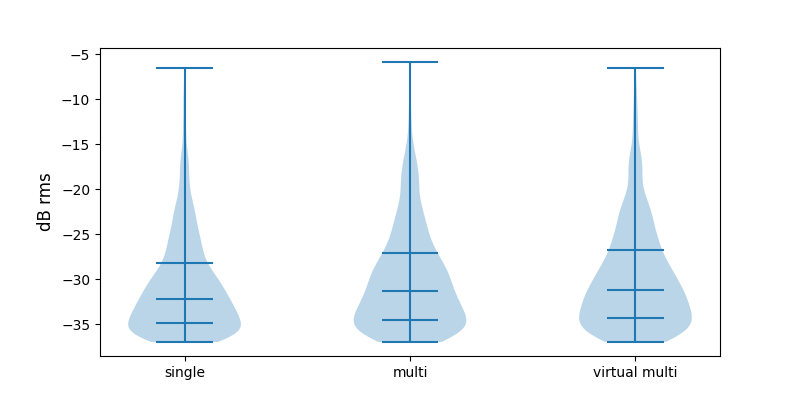

Text(0, 0.5, 'dB rms')

In [18]:
make_inspection_and_comparison_plot(all_measures, 'rms', dB)
plt.ylabel('dB rms')

### Dominant frequencies

<IPython.core.display.Javascript object>


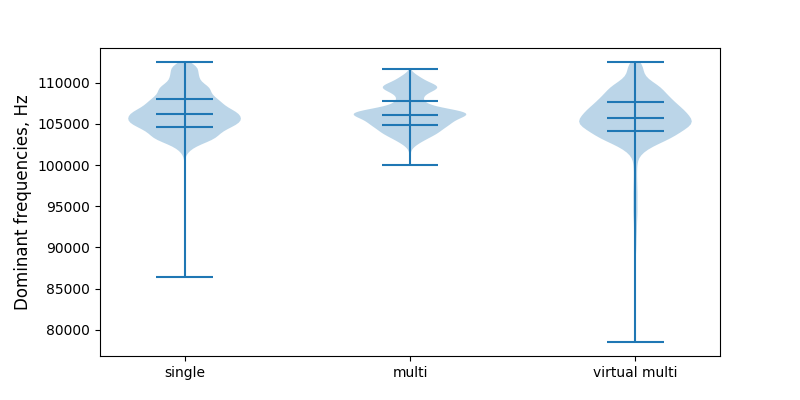

Text(0, 0.5, 'Dominant frequencies, Hz')

In [19]:
make_inspection_and_comparison_plot(all_measures, 'dominant_frequencies')
plt.ylabel('Dominant frequencies, Hz')

### Lower frequency (-46 dB of peak frequency)

<IPython.core.display.Javascript object>


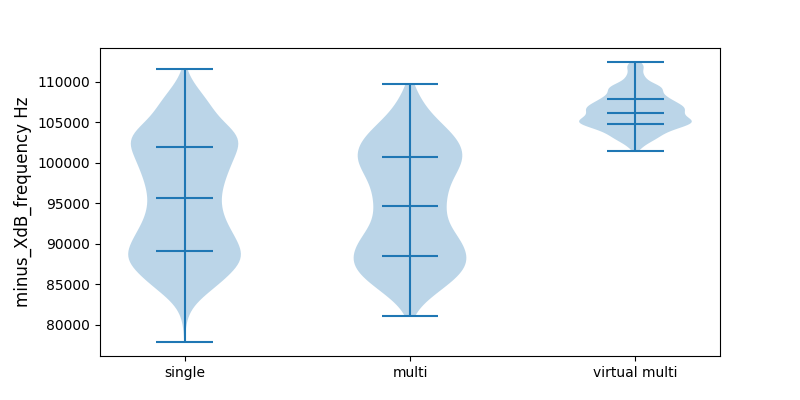

Text(0, 0.5, 'minus_XdB_frequency Hz')

In [20]:
make_inspection_and_comparison_plot(all_measures, 'minus_XdB_frequency')
plt.ylabel('minus_XdB_frequency Hz')

## Calculate the bootstrapped medians for all the relevant parameters across the three group sizes



In [97]:
total_runs = 500
median_rms = bootstrapped_median_distribution(all_measures,'rms',
                                                  just_return_input, dB, Nruns=total_runs, parallel=True)
median_peakamp = bootstrapped_median_distribution(all_measures,'peak_amplitude',
                                                  just_return_input, dB, Nruns=total_runs, parallel=True)

100%|██████████| 500/500 [05:41<00:00,  1.46it/s]


<IPython.core.display.Javascript object>


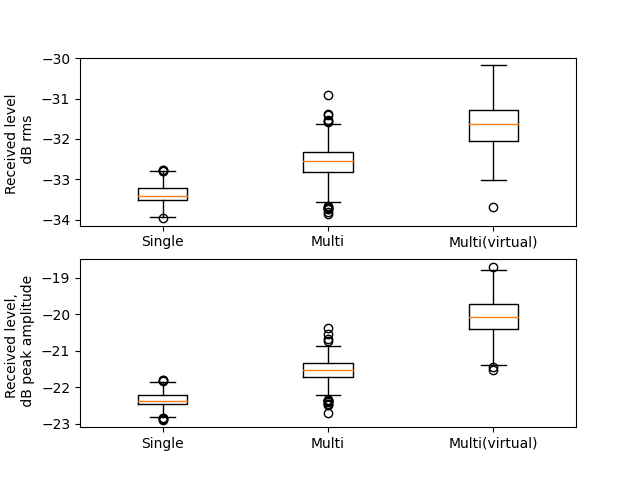

([<matplotlib.axis.XTick at 0x7fb1b551e828>,
 [Text(0, 0, 'Single'), Text(0, 0, 'Multi'), Text(0, 0, 'Multi(virtual)')])

In [108]:
xlab_median_plot = lambda X: plt.xticks([1,2,3],['Single','Multi','Multi(virtual)'])

plt.figure()
a0=plt.subplot(211)
plt.boxplot(median_rms);
plt.ylabel('Received level \n dB rms')
xlab_median_plot(0)
plt.subplot(212)
plt.boxplot(median_peakamp)
plt.ylabel('Received level, \n dB peak amplitude')
xlab_median_plot(0)

In [109]:
median_lowerfreq = bootstrapped_median_distribution(all_measures,'minus_XdB_frequency',
                                                  just_return_input, just_return_input, Nruns=total_runs,
                                                  parallel=True)

100%|██████████| 500/500 [04:54<00:00,  1.70it/s]


<IPython.core.display.Javascript object>


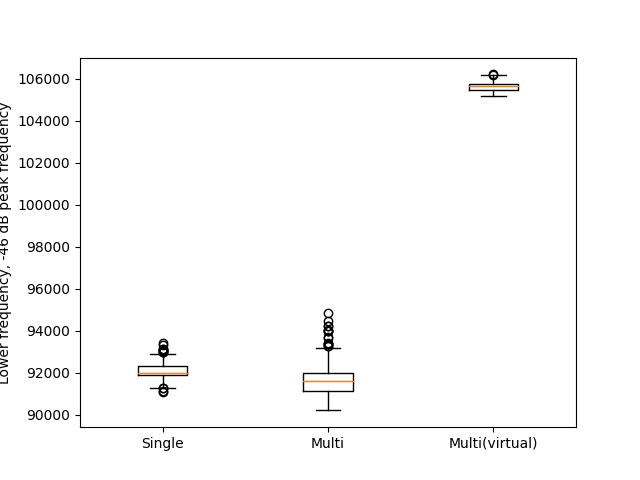

([<matplotlib.axis.XTick at 0x7fb1b5452588>,
 [Text(0, 0, 'Single'), Text(0, 0, 'Multi'), Text(0, 0, 'Multi(virtual)')])

In [110]:
plt.figure()
plt.boxplot(median_lowerfreq);
plt.ylabel('Lower frequency, -46 dB peak frequency')
xlab_median_plot(0)